In [0]:
pip install pydicom

     |████████████████████████████████| 7.0MB 4.1MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/')

In [0]:
!ls

 backup
 brucechou1983_CheXNet_Keras_0.3.0_weights.h5
 cfg
'Colab Notebooks'
 darknet
 darknet1
 darknet53.conv.74
 darknet53.conv.74.1
 darknet_gpu
 darknet_weights
'GCP Credits Request Link - RSNA.txt'
 images
 Lab4_smartTaxi_QlearningSARSA.ipynb
 Lab6_HandsOn_frozenLake8x8_QlearningSARSA.ipynb
 labels
 metadata
 Resnet101_rsna_pneumonia_detection_challenge_kaggle.ipynb
 SMS_NER
 stage_2_detailed_class_info.csv
 stage_2_sample_submission.csv
 stage_2_test_images
 stage_2_test_images.zip
 stage_2_train_images
 stage_2_train_images.zip
 stage_2_train_labels.csv
 train_log.txt


In [0]:
from zipfile import ZipFile
with ZipFile('stage_2_train_images.zip', 'r') as z:
  z.extractall('stage_2_train_images')

In [0]:
from zipfile import ZipFile
with ZipFile('stage_2_test_images.zip', 'r') as z:
  z.extractall('stage_2_test_images')


In [0]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
#import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [0]:
random_stat = 123
np.random.seed(random_stat)

In [0]:
!git clone https://github.com/pjreddie/darknet.git

# Build gpu version darknet
!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
!cd darknet && make -j 999 -s
!cp darknet/darknet darknet_gpu

fatal: destination path 'darknet' already exists and is not an empty directory.
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:947:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~


In [0]:
DATA_DIR = "/content/drive/My Drive/"

train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [0]:
!ls -shtl

total 3.9G
1.9M -rw-------  1 root root 1.9M Jul  6 09:30  darknet_gpu
4.0K drwx------ 14 root root 4.0K Jul  6 09:30  darknet
4.0K drwx------  2 root root 4.0K Jul  6 09:29  stage_2_train_images
 28M -rw-------  1 root root  28M Jun 24 12:37  brucechou1983_CheXNet_Keras_0.3.0_weights.h5
340K -rw-------  1 root root 340K Jun 23 07:36  Resnet101_rsna_pneumonia_detection_challenge_kaggle.ipynb
488K -rw-------  1 root root 488K Jun 23 06:45  Lab4_smartTaxi_QlearningSARSA.ipynb
7.0K -rw-------  1 root root 6.9K Jun 23 06:44  Lab6_HandsOn_frozenLake8x8_QlearningSARSA.ipynb
   0 -rw-------  1 root root    0 Jun 22 07:52  train_log.txt
1.9M -rw-------  1 root root 1.9M Jun 22 07:30  darknet1
4.0K drwx------  2 root root 4.0K Jun 22 06:14  darknet_weights
4.0K drwx------  2 root root 4.0K Jun 18 06:53  SMS_NER
4.0K drwx------  2 root root 4.0K Jun 17 18:56  stage_2_test_images
4.0K drwx------  2 root root 4.0K Jun 17 11:20  backup
4.0K drwx------  2 root root 4.0K Jun 17 11:20  cfg
4.0K drwx--

In [0]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        # Since kaggle kernel have samll volume (5GB ?), I didn't contain files with no bbox here.
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [0]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

In [0]:
!du -sh images labels

1.5G	images
3.0M	labels


0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



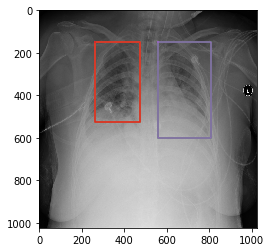

In [0]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [0]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [0]:
# Following lines do not contain data with no bbox
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 5410, The # of validation set: 602


In [0]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [0]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)

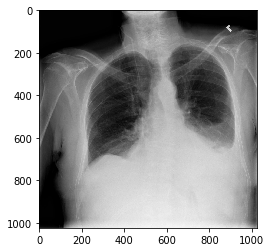

In [0]:
ex_patient_id = test_dcm_fps[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

In [0]:
 #cfg/rsna.data
 #cfg/rsna.names
 #darknet53.conv.74
 #cfg/rsna_yolov3.cfg_train

In [0]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [0]:
!cat cfg/rsna.data

classes= 1
train  = /content/drive/My Drive/metadata/tr_list.txt
valid  = /content/drive/My Drive/metadata/val_list.txt
names  = /content/drive/My Drive/cfg/rsna.names
backup = /content/drive/My Drive/backup
    

In [0]:
# Label list of bounding box.
!echo "pneumonia" > cfg/rsna.names

In [0]:
!wget -q https://pjreddie.com/media/files/darknet53.conv.74

In [0]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=18ptTK4Vbeokqpux8Onr0OmwUP9ipmcYO" -O cfg/rsna_yolov3.cfg_train

In [0]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders


!tar -xzvf /content/drive/My\ Drive/darknet/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
#content/drive/My Drive/darknet/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz
!chmod a+r /usr/local/cuda/include/cudnn.h




cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a


In [0]:
# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [0]:
!ls -l
!chmod 777 /content/drive/My Drive/*


total 4190181
drwx------ 2 root root       4096 Jun 17 11:20  backup
-rw------- 1 root root   29144256 Jun 24 12:37  brucechou1983_CheXNet_Keras_0.3.0_weights.h5
drwx------ 2 root root       4096 Jul  7 18:42  cfg
drwx------ 2 root root       4096 Jan 18 13:37 'Colab Notebooks'
drwx------ 3 root root       4096 Jun 22 06:19  darknet
-rw------- 1 root root    1971216 Jun 22 07:30  darknet1
-rw------- 1 root root  162482580 Mar 25  2018  darknet53.conv.74
-rw------- 1 root root  162482580 Mar 25  2018  darknet53.conv.74.1
-rw------- 1 root root    1971216 Jul  6 09:31  darknet_gpu
drwx------ 2 root root       4096 Jun 22 06:14  darknet_weights
-rw------- 1 root root         55 Jun 17 09:10 'GCP Credits Request Link - RSNA.txt'
drwx------ 2 root root       4096 Jun 17 11:20  images
-rw------- 1 root root     499505 Jun 23 06:45  Lab4_smartTaxi_QlearningSARSA.ipynb
-rw------- 1 root root       7041 Jun 23 06:44  Lab6_HandsOn_frozenLake8x8_QlearningSARSA.ipynb
drwx------ 2 root root       4

In [0]:
!chmod +x ./darknet1

In [0]:
!ls -l

total 4190181
drwx------ 2 root root       4096 Jun 17 11:20  backup
-rw------- 1 root root   29144256 Jun 24 12:37  brucechou1983_CheXNet_Keras_0.3.0_weights.h5
drwx------ 2 root root       4096 Jul  7 18:57  cfg
drwx------ 2 root root       4096 Jan 18 13:37 'Colab Notebooks'
drwx------ 3 root root       4096 Jun 22 06:19  darknet
-rwx------ 1 root root    1971216 Jun 22 07:30  darknet1
-rw------- 1 root root  162482580 Mar 25  2018  darknet53.conv.74
-rw------- 1 root root  162482580 Mar 25  2018  darknet53.conv.74.1
-rw------- 1 root root    1971216 Jul  6 09:31  darknet_gpu
drwx------ 2 root root       4096 Jun 22 06:14  darknet_weights
-rw------- 1 root root         55 Jun 17 09:10 'GCP Credits Request Link - RSNA.txt'
drwx------ 2 root root       4096 Jun 17 11:20  images
-rw------- 1 root root     499505 Jun 23 06:45  Lab4_smartTaxi_QlearningSARSA.ipynb
-rw------- 1 root root       7041 Jun 23 06:44  Lab6_HandsOn_frozenLake8x8_QlearningSARSA.ipynb
drwx------ 2 root root       4

In [0]:
!./darknet1 detector train "/content/drive/My Drive/cfg/rsna.data" "/content/drive/My Drive/darknet/cfg/rsna_yolov3.cfg" "/content/drive/My Drive/darknet53.conv.74" -i

rsna_yolov3
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8           